In [195]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
import torch
import data_loader, models, train
from matplotlib import pyplot as plt
import numpy as np

In [206]:
hidden_dim = 400
latent_dim = 200
c = 1
batch_size = 64

lr = 1e-3
epochs = 10

is_cuda = True

In [207]:
dataloader_train, dataloader_valid = data_loader.CustomDataloaders.MNIST()
if is_cuda:
    device = torch.device('cuda:0')
else:   
    device = torch.device('cpu')
model = models.VaeFc(hidden_dim=hidden_dim, latent_dim=latent_dim, c=c).to(device)

In [208]:
#### Training script

optim = torch.optim.Adam(model.parameters(), lr=lr)
epoch_loss = 0

for epoch in range(epochs):
    print(f'Epoch: {epoch:2}')
    nb_items = 0
    epoch_loss = 0
    for n, batch in enumerate(dataloader_train):
        model.train()
        x, _ = batch
        x = x.to(device)
        y_hat, mean, logvar = model.forward_train(x)
        loss = model.calculate_loss(x, y_hat, mean, logvar)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_loss += loss.detach()
        if (n+1)%2000 == 0:
            print(f'    loss: {loss:12.3f}')
    print(f'  epoch loss: {epoch_loss/n:5.3f}')
print('Training Complete')

        

Epoch:  0
  epoch loss: 172.929
Epoch:  1
  epoch loss: 125.996
Epoch:  2
  epoch loss: 113.332
Epoch:  3
  epoch loss: 107.394
Epoch:  4
  epoch loss: 104.183
Epoch:  5
  epoch loss: 101.924
Epoch:  6
  epoch loss: 99.931
Epoch:  7
  epoch loss: 98.657
Epoch:  8
  epoch loss: 97.705
Epoch:  9
  epoch loss: 96.903
Training Complete


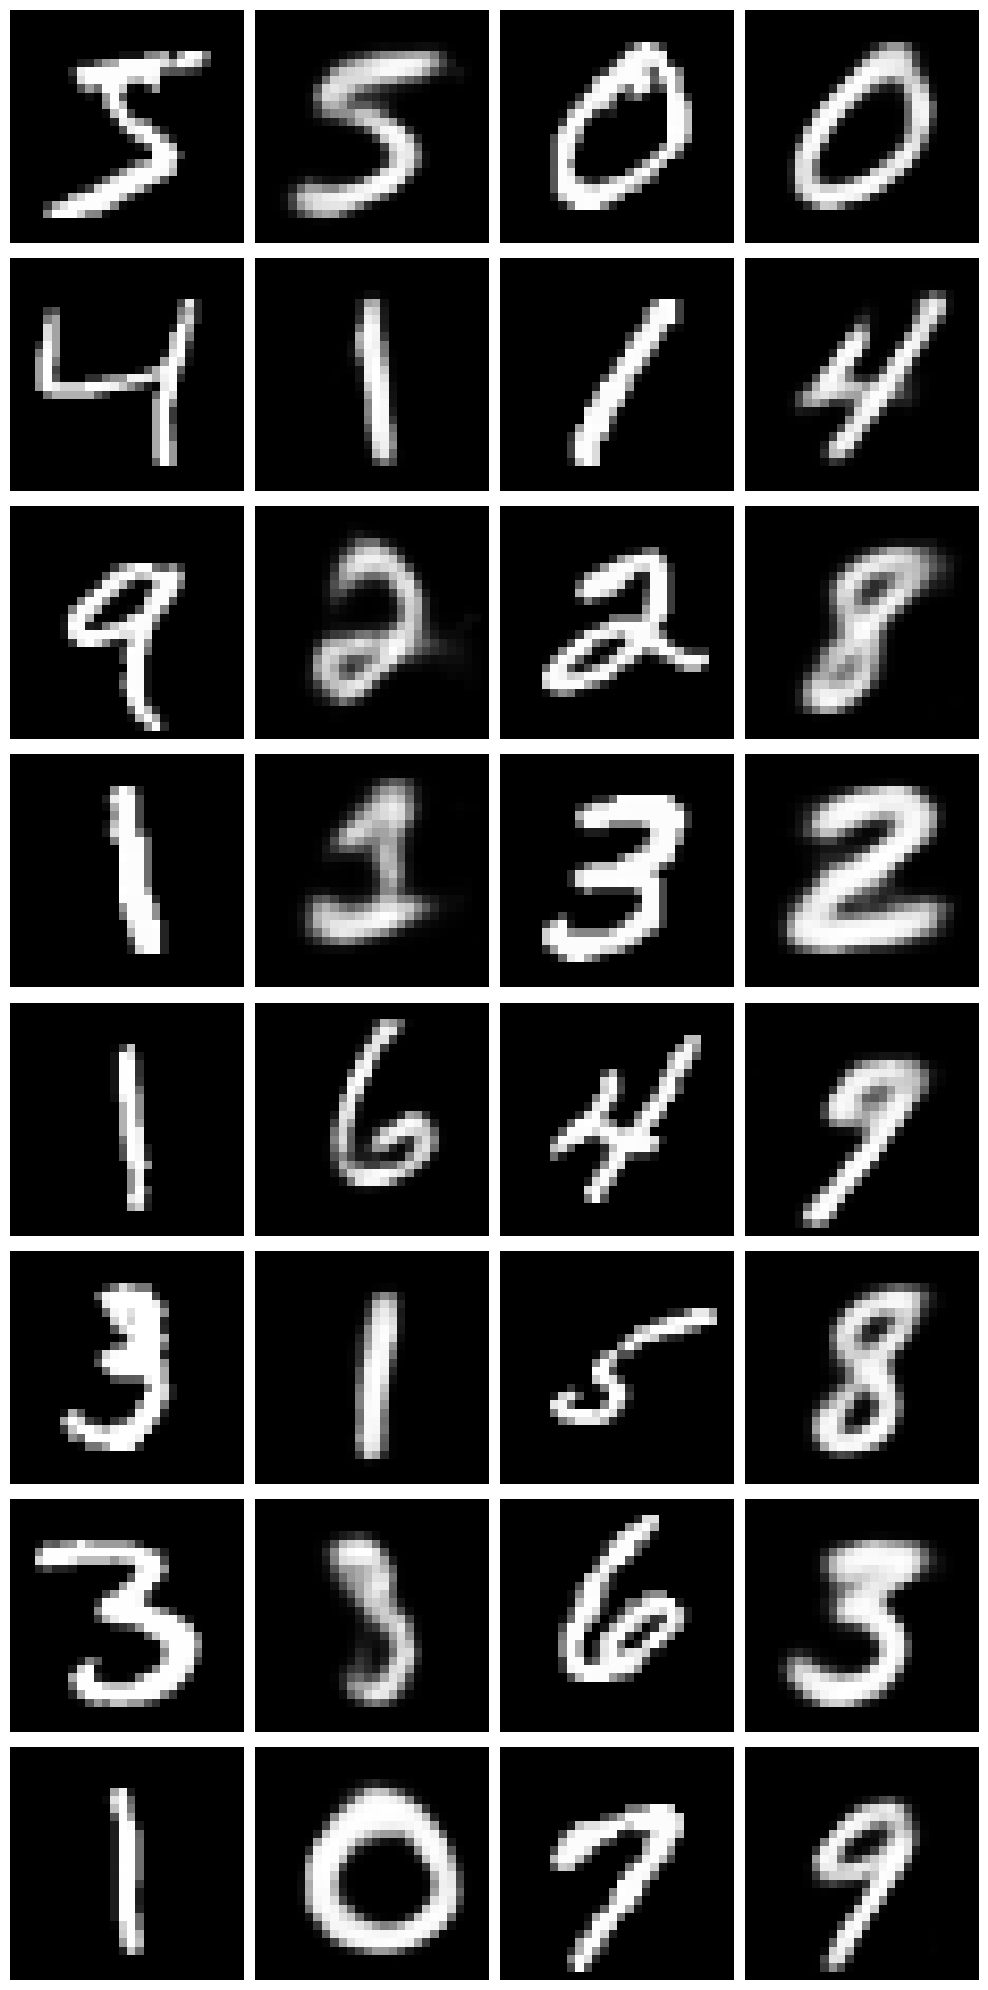

In [209]:
model.eval()
model.to('cpu')
x, _ = next(iter(dataloader_train))
x_hat = model(x)

# Create a figure and axes for plotting
fig, axs = plt.subplots(nrows=8, ncols=4, figsize=(10, 20))
rows = 8
cols = 4

# Loop through each row
for i in range(rows):
    # Alternate between x and x_hat in each row
    for j in range(cols):
        if j % 2 == 0:
            img = x[i * (cols // 2) + (j // 2)][0].detach().numpy()  # Extracting an image from x
        else:
            img = x_hat[i * (cols * 2) + (j // 2)][0].detach().numpy()  # Extracting an image from x_hat

        # Plot the image
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].axis('off')

# Show the plot
plt.tight_layout()
plt.show()
